# Showcasing pcrglobwb_utils

This notebook should provide a first impression on what the pcrglobwb_utils package and the functions therein can contribute to evaluating PCR-GLOBWB runs and output.

It contains:

* Extracting meta-data information from [GRDC-stations](#GRDC_info) (name, location);
* [Extracting timeseries](#get_data) from GRDC-file and netCDF-file at specified cell;
* [Validation](#validate) of simulated data with observations;
* [Resampling](#resampling) to different frequencies and using different statistical descriptors;
* Evaluate the different components of the annual [water balance](#water_balance)
* Analyse [ensemble data](#ensembles)
* Validate PCR-GLOBWB output against [GRACE and GLEAM data](#GRACE_and_GLEAM)

## Preparation

### Load packages

In [1]:
import pcrglobwb_utils
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import spotpy as sp
import os, sys
import datetime

Always handy to get some information on which system and with which version the notebook was run!

In [2]:
print('this notebook was created using Python', str((sys.version)), 'on a', str(sys.platform),'on', datetime.datetime.now())

this notebook was created using Python 3.8.2 | packaged by conda-forge | (default, Mar  5 2020, 17:29:01) [MSC v.1916 64 bit (AMD64)] on a win32 on 2020-09-10 13:48:50.950241


In [3]:
print('using pcrglobwb_utils version', pcrglobwb_utils.__version__)

using pcrglobwb_utils version 0.1.4.4b1


### specify variable names

# Working with timeseries

<a id="GRDC_info"></a>

## Get information about GRDC-station and its location

A data source often used for validating simulated discharge is the Global Runoff Data Centre ([GRDC](https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#)). With the functions implemented in pcrglobwb_utils, it becomes much more straightforward to validate simulated discharge with observations. All is needed is the nc-file containing simulated discharge and the GRDC-file containing observed values.

By means of a GRDC-file containing daily discharge for the station Obidos in the Amazon River basin, the workflow is explained. First, we read the file which forms the basis for all subsequent steps.

In [4]:
##- create a python-object for the GRDC-data, here daily values
grdc_data = pcrglobwb_utils.obs_data.grdc_data('example_data/3629000_Obidos.day')

As long as the file follows the 'default' GRDC-format, the tool parses the content to find the right entries. This is used to return some important meta-data about the station.

In [5]:
##- get a simple plot_title and properties (as dictionary) for this GRDC station
plot_title, props = grdc_data.get_grdc_station_properties()
print(plot_title)
print(props)

station OBIDOS - PORTO at latitude/longitude -1.947200/-55.511100
{'station': 'OBIDOS - PORTO', 'latitude': -1.9472, 'longitude': -55.5111}


We now know where this specific location is located based on lat/lon information. This in turn can be employed to find the corresponding cell in the netCDF-file and extract a timeseries of simulated discharge from there.

In [6]:
##- based on lon/lat information of GRDC station, find corresponding row/col indices in nc-file
row, col = pcrglobwb_utils.utils.find_indices_from_coords('example_data/DUMMY_discharge_dailyTot_output.nc', 
                                                          props['longitude'], props['latitude'])

print('The location {} with its latitude {} and longitude {} corresponds to the cell with row and cell indeces {}'.format(props['station'], 
                                                                                                                         props['latitude'], 
                                                                                                                         props['longitude'],
                                                                                                                         (row, col)))

The location OBIDOS - PORTO with its latitude -1.9472 and longitude -55.5111 corresponds to the cell with row and cell indeces (17, 50)


Sometimes, the  river network and the coordinates provided in the GRDC-file do not match. Let's have a visual check if this is the case here as well or not. 'pcrglobwb_utils' provides a wrapper to plot the data of a nc-file with a given variable name at a certain date.

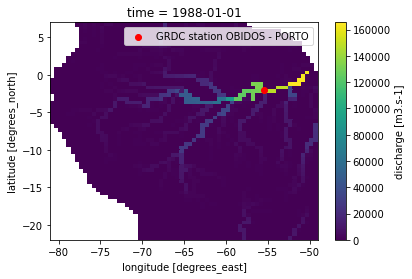

In [7]:
plt.figure()
pcrglobwb_utils.plotting.plot_var_at_timestep('example_data/DUMMY_discharge_dailyTot_output.nc', 
                                              var_name='discharge', 
                                              time='1988-01-01')
plt.scatter(props['longitude'], props['latitude'], c='r', label='GRDC station {}'.format(props['station']))
plt.legend();

Fortunately, the river network and coordinates match! We are not ready to extract timeseries from both the GRDC and PCR-GLOBWB files!

<a id="get_data"></a>

## Reading values files and visualzing them

### From GRDC file

We already know the station name, where the GRDC-station is located, and that river network and coordinates match. Now let's get to the pudels kern and get the timeseries of observed discharge at this station.

Let's check the daily discharge data at Obidos. We can directly plot the timeseries and give it a user-specified variable name.

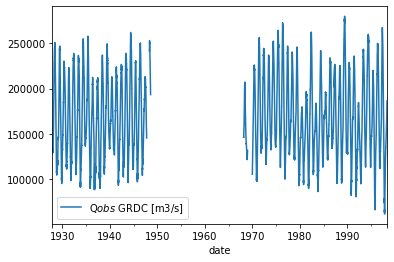

In [8]:
df_GRDC, props = grdc_data.get_grdc_station_values(var_name='Q$obs$ GRDC [m3/s]', plot=True)

Once we have retrieved the timeseries, the station properties are updated with the startdate and enddate of observations. Note, that this does not say anything about the number of missing values in this timeseries and when they occur!

In [9]:
print('Start data of the observations is {} and the end data is {}'.format(props['start_data_obs'], props['end_data_obs']))

Start data of the observations is 12/01/1927 and the end data is 05/31/1998


### From Excel file

Observed discharge is not always retrieved from the GRDC. If the file is not structured like GRDC files but a simple Excel-file with one (!) sheet containing two columns (date and value), we could do the same by reading from a non-GRDC formatted Excel-file. In this case, we do of course miss the station meta-data.

*Note: for this example the GRDC data was copied into an Excel-file, thus the absolute agreement between both timeseries.*

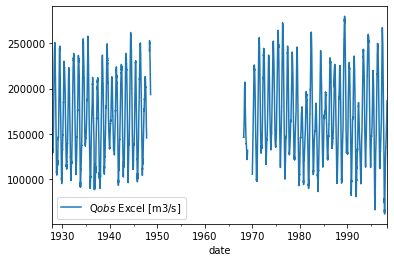

In [10]:
##- first, create a python-object 
excel_data = pcrglobwb_utils.obs_data.other_data('example_data/Obidos_data.xlsx')

# second, apply method
df_excel = excel_data.get_values_from_excel(var_name='Q$obs$ Excel [m3/s]',
                                     plot=True,
                                     remove_mv=True)

### From nc-file

Thus far, we looked merely at observed values. Time to check out the simulated values too! To that end, we first read the netCDF-file containing simulated discharge data. 

In [11]:
pcr_data = pcrglobwb_utils.sim_data.from_nc('example_data/DUMMY_discharge_dailyTot_output.nc')

Above, we already determined the row and column indices of the GRDC-station we use for model validation. These indices now serve as input to retrieve the timeseries from the netCDF-file and store it as dataframe. Again, the user can specify a variable name.

In [12]:
# apply method to read values at specific row and col
q_sim_obidos = pcr_data.read_values_at_indices(row, col, plot_var_name='Q$sim$ PCR-GLOBWB [m3/s]', plot=False)

Together with the above-retrieved dataframe containing the observed values, we can now finally compare the timeseries!

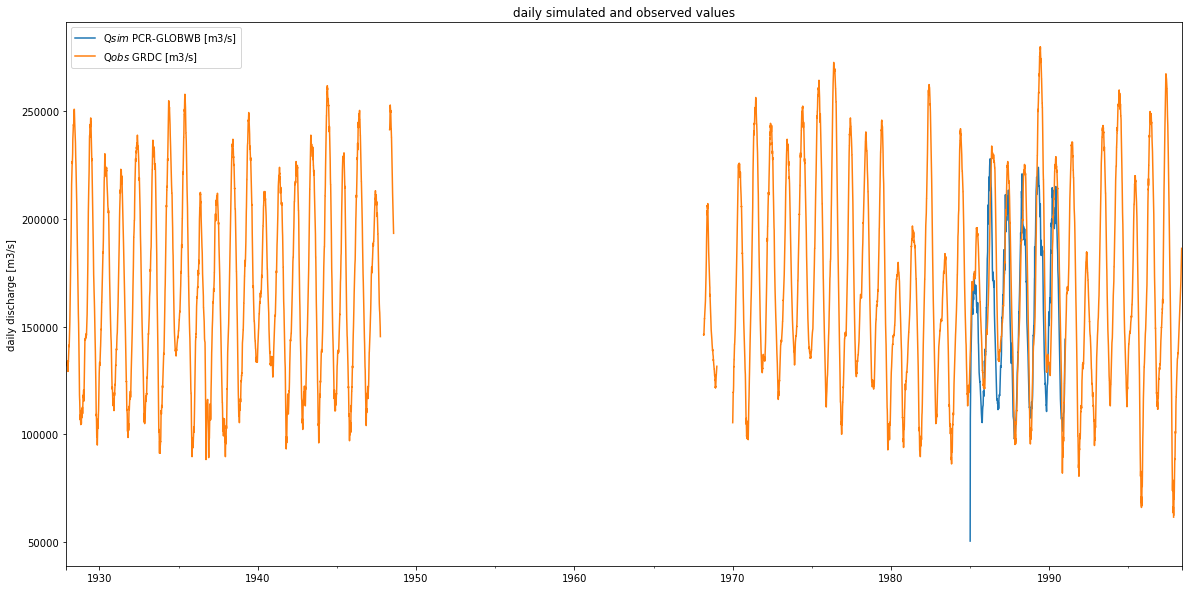

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
q_sim_obidos.plot(ax=ax)
df_GRDC.plot(ax=ax)
ax.set_ylabel('daily discharge [m3/s]')
ax.set_xlabel(None)
plt.legend()
plt.title('daily simulated and observed values');

<a id="validate"></a>

## Validation of daily values

Eventually, we do not only want to look at timeseries, but validate the accuracy of simulated discharge wiht observation. Currently, we can compute the KGE (with or without its components), NSE, RMSE, and R2 based on simulations and observations. To do so, both timeseries need to be clipped to the common period and missing values are removed.

In [14]:
df_eval, eval_dic = pcr_data.validate_results(df_GRDC, out_dir='./_OUT', return_all_KGE=True)

In [15]:
print('Calculated KGE is {0:0.2f}, NSE is {1:0.2f}, RMSE = {2:0.2f}, and R2 = {3:0.2f}'.format(eval_dic['KGE'][0],
                                                                                               eval_dic['NSE'],
                                                                                               eval_dic['RMSE'],
                                                                                               eval_dic['R2']))

Calculated KGE is 0.71, NSE is 0.50, RMSE = 30911.84, and R2 = 0.60


In [16]:
print('in case it is specified, the components of the KGE are: correlation {0:0.2f}, ratio of the standard deviation {1:0.2f}, and ratio of the mean {2:0.2f}'.format(eval_dic['KGE'][1],
                                                                                                                                                    eval_dic['KGE'][2],
                                                                                                                                                    eval_dic['KGE'][3]))

in case it is specified, the components of the KGE are: correlation 0.77, ratio of the standard deviation 0.84, and ratio of the mean 0.92


In case the statistical properties of the timeseries are of interest, this can be provided as well. If needed, the properties of observed data can be included as well.

In [17]:
stats = pcr_data.calc_stats(out_dir='./_OUT', add_obs=False)
stats

,Q$sim$ PCR-GLOBWB [m3/s]
count,2191.000000
mean,157987.046875
std,36602.886719
min,50378.406250
25%,123427.542969
50%,157203.796875
75%,191713.609375
max,228026.765625


<a id="resampling"></a>

## Resampling over time using different statistical descriptors

### Averaging

It is also possible to resample timeseries from, for instance, daily values to monthly or even yearly values. Thereby, the resampling can be done using the monthly/yearly mean (default setting) or used to determine minimum and maximum mean value per month or year.

In [18]:
q_sim_obidos_monthly = pcr_data.resample2monthly(stat_func='mean', suffix='_monthly')
q_sim_obidos_monthlyMAX = pcr_data.resample2monthly(stat_func='max', suffix='_monthly')
q_sim_obidos_monthlyMIN = pcr_data.resample2monthly(stat_func='min', suffix='_monthly')

By using min, mean, and max monthly values, the boundaries of discharg can be plotted nicely.

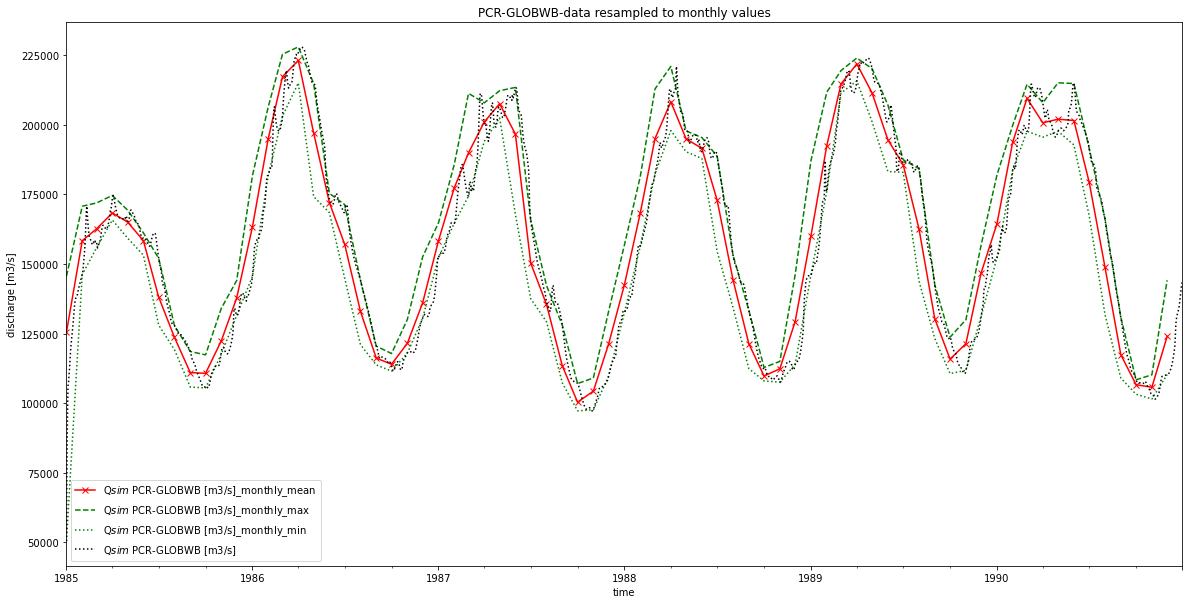

In [19]:
ax = q_sim_obidos_monthly.plot(c='r', marker='x', figsize=(20,10))
q_sim_obidos_monthlyMAX.plot(ax=ax, c='g', linestyle='--')
q_sim_obidos_monthlyMIN.plot(ax=ax, c='g', linestyle=':')
q_sim_obidos.plot(ax=ax, c='k', linestyle=':', title='PCR-GLOBWB-data resampled to monthly values')
ax.set_ylabel('discharge [m3/s]');

Similarly, we can do this for observed discharge.

In [20]:
GRDC_data_monthly = grdc_data.resample2monthly(stat_func='mean', suffix='_monthly')

With this, the monthly average discharge from both observations and simulation can be plotted.

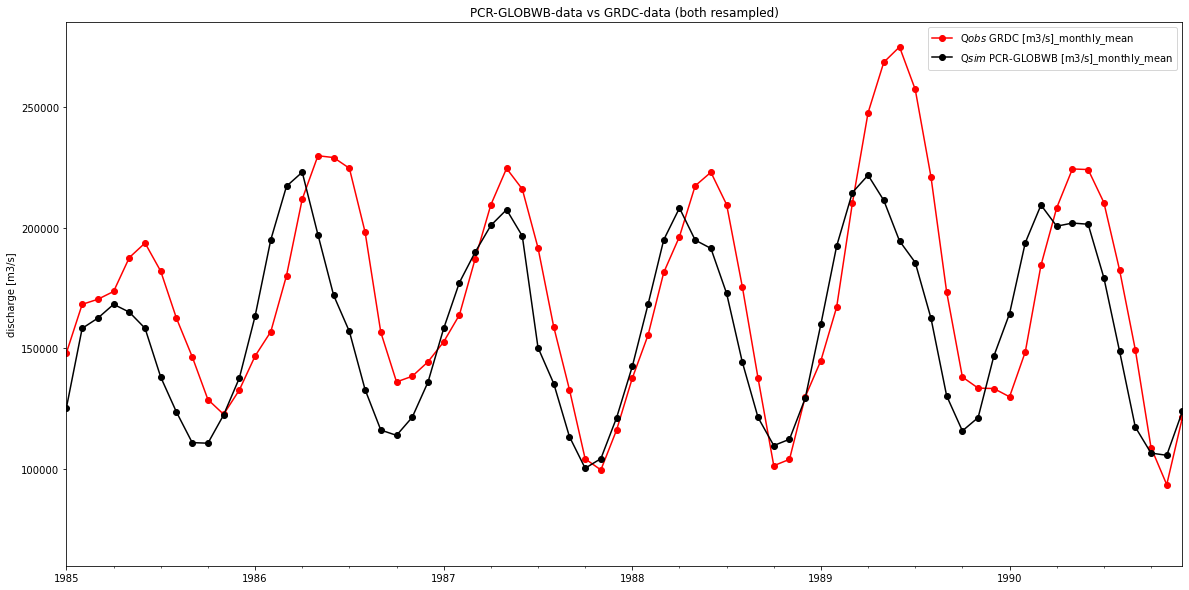

In [21]:
ax = GRDC_data_monthly.plot(c='r', marker='o', figsize=(20,10))
q_sim_obidos_monthly.plot(ax=ax, c='k', marker='o', title='PCR-GLOBWB-data vs GRDC-data (both resampled)')
ax.set_ylabel('discharge [m3/s]')
ax.set_xlabel(None)
ax.set_xlim(q_sim_obidos_monthly.index.values[0], q_sim_obidos_monthly.index.values[-1]);

<a id="water_balance"></a>

# Analyzing the water balance of a run

By parsing the water balance statements in the log file, it is possible to get the annual values of different water balance components.

In [22]:
# first, create a water balance object based on the log-file
wb = pcrglobwb_utils.water_balance.water_balance('example_data/setup_30min_Amazon_2005_2010_para.log')

In [23]:
# now get annual values of the components
wb.get_annual_values()

,year,precipitation,actualET,runoff,totalPotentialGrossDemand,baseflow,storage
0,2004,19290.19,8567.613,7803.257,0.0,6236.654,2919.32300
1,2005,19323.89,8585.006,8773.407,0.0,7164.631,1965.49800
2,2006,20774.36,8639.188,10510.080,0.0,8836.278,1625.08700
3,2007,19292.14,8477.911,10059.490,0.0,8551.246,754.76360
4,2008,20996.61,8543.917,11480.840,0.0,9886.425,971.79970
5,2009,19872.88,8748.335,11157.260,0.0,9630.766,-32.68977


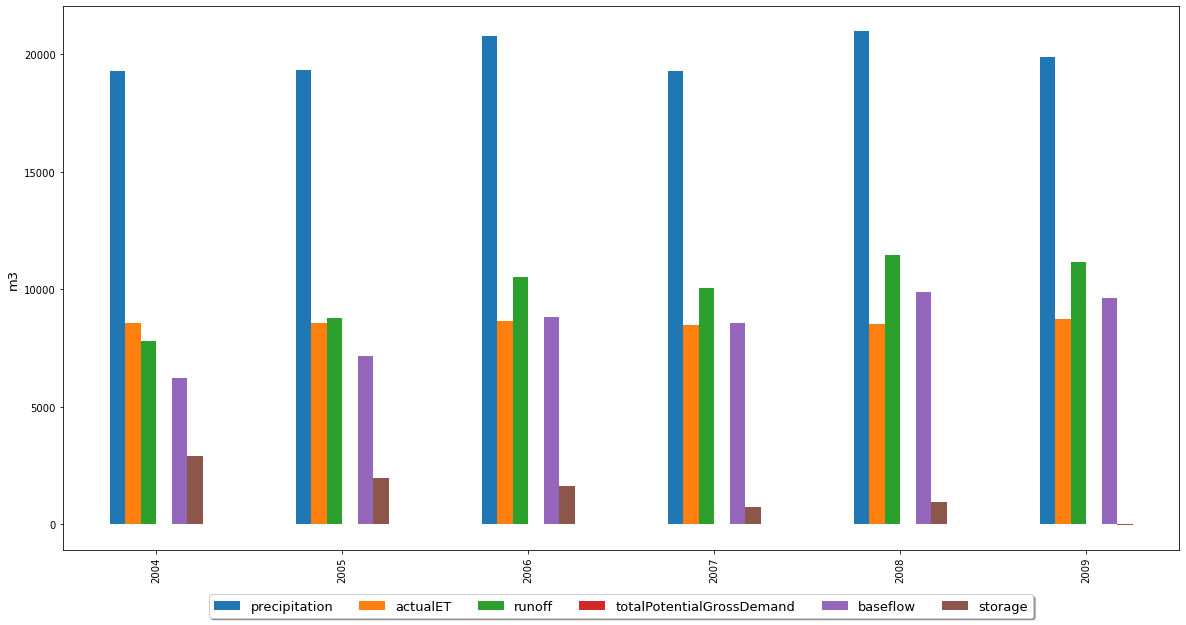

In [24]:
# it is also possible to directly plot them as bar plot
wb.bar_plot()

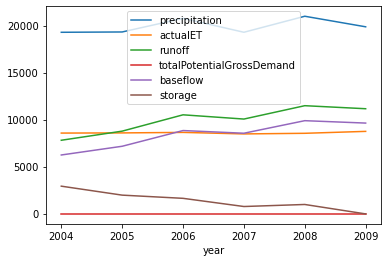

In [25]:
# alternatively, the dataframe can be retrieved and all pandas plotting options are available
wb_vals = wb.get_annual_values()
wb_vals.plot(x='year')

<a id="ensembles"></a>

# Ensembles

If more than one run is performed but an ensemble (e.g. with different RCPs), it can be useful to automatically compute and vizualize the mean, max, and min of the ensemble. pcrglobwb_utils contains a few functions to facilitate working with ensembles.

Since we only have output from one run here, we compute some dummy time series first by multiplying the actual data with random factors.

In [26]:
##- get some random values for the factors
fact_arr = np.random.rand(9)

In [27]:
##- create a list with dummy timeseries, representing a range of ensemble runs
q_ens = [q_sim_obidos]
for factor, i in zip(fact_arr, range(len(fact_arr))):
    q_temp = q_sim_obidos.mul(factor)
    q_temp = q_temp.rename(columns={'Q$sim$ PCR-GLOBWB [m3/s]': i+1})
    q_ens.append(q_temp)

The code currently works like this that you need to separately provide a dataframe per ensemble you want to have analysed. This gives more flexibilty in handling the data input.

In [28]:
ens_obj = pcrglobwb_utils.ensembles.ensemble_data(q_ens[0], q_ens[1], q_ens[2], q_ens[4], q_ens[5], q_ens[9])

We can now calculate the mean, max, and min of the timeseries.

In [29]:
df_ens = ens_obj.calc_stats()
df_ens.head()

,Q$sim$ PCR-GLOBWB [m3/s],1,2,4,5,9,mean,max,min
time,,,,,,,,,
1985-01-01,50378.406250,21554.203125,25849.222656,22095.947266,37120.601562,49012.687500,34335.175781,50378.406250,21554.203125
1985-01-02,80150.671875,34292.148438,41125.406250,35154.050781,59057.863281,77977.851562,54626.328125,80150.671875,34292.148438
1985-01-03,95131.804688,40701.769531,48812.246094,41724.765625,70096.492188,92552.859375,64836.656250,95131.804688,40701.769531
1985-01-04,106136.960938,45410.281250,54459.003906,46551.625000,78205.484375,103259.671875,72337.179688,106136.960938,45410.281250
1985-01-05,107144.250000,45841.246094,54975.843750,46993.421875,78947.687500,104239.656250,73023.679688,107144.250000,45841.246094


Furthermore, this information allows us to plot the span of values per timestep as a graph.

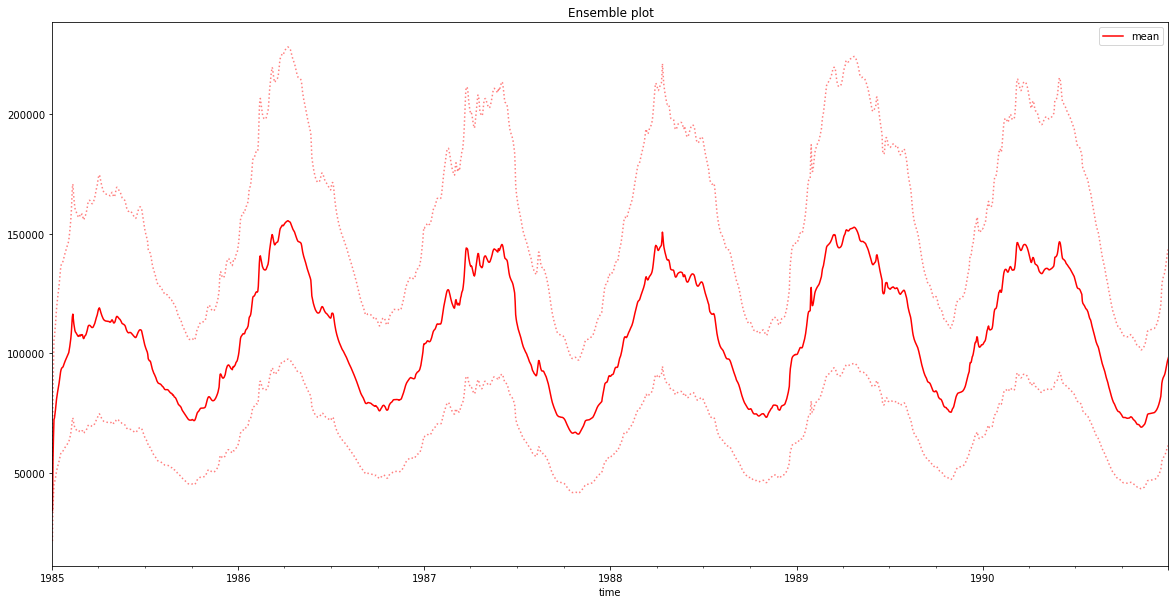

In [30]:
ens_obj.plot_bounds()

### Climatology

Sometimes it is good to know what the mean value is per month averaged the entire timeseries. This can be done with the subsequent function.

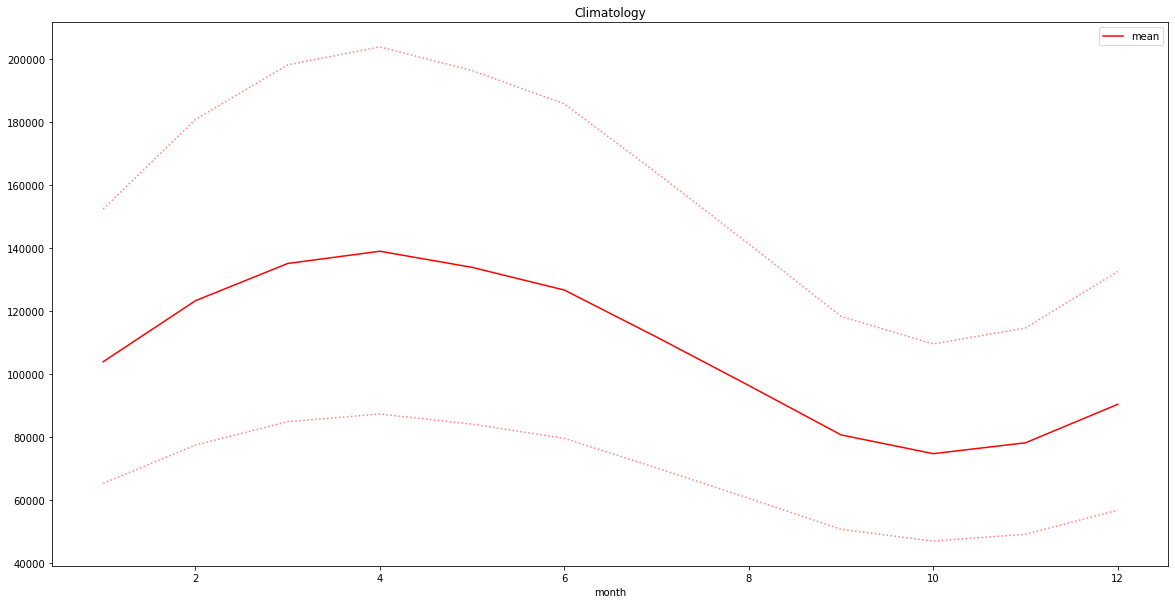

In [31]:
df_ens_monthAvg = ens_obj.climatology(plot=True);

<a id="GRACE_and_GLEAM"></a>

## GRACE and GLEAM validation

Besides timeseries of discharge, it is often necessary to validate other model output, for example totalWaterStorage and totalEvaporation.

With the functions provided, this can easily be done for a given area specified with a shape-file. The code clips observed and simulated data to the area extent and averages over the area per time step. This yields a timeseries again, for which r and RMSE can be computed.

In [32]:
TZA_waterProvinces = pcrglobwb_utils.spatial_validation.validate_per_shape(shp_fo='example_data/Tanzania_shp/waterProvinces.shp',
                                                                           shp_key='watprovID')

reading shp-file C:\Users\hoch0001\Documents\_code\pcrglobwb_utils\examples\example_data\Tanzania_shp\waterProvinces.shp


reading GRACE file C:\Users\hoch0001\Documents\_code\pcrglobwb_utils\examples\example_data\GRACE\GRACE_data_2010_Tanzania.nc
reading PCR-GLOBWB file C:\Users\hoch0001\Documents\_code\pcrglobwb_utils\examples\example_data\GRACE\totalWaterStorageThickness_monthAvg_output_2010_Tanzania.nc
extract raw data from nc-files
clipping nc-files to extent of shp-file
computing R and RMSE for polygon with key identifier watprovID 25
computing R and RMSE for polygon with key identifier watprovID 28
computing R and RMSE for polygon with key identifier watprovID 29
computing R and RMSE for polygon with key identifier watprovID 30
computing R and RMSE for polygon with key identifier watprovID 31
computing R and RMSE for polygon with key identifier watprovID 32
computing R and RMSE for polygon with key identifier watprovID 33
computing R and RMSE for polygon with key identifier watprovID 443
computing R and RMSE for polygon with key identifier watprovID 444
computing R and RMSE for polygon with key iden

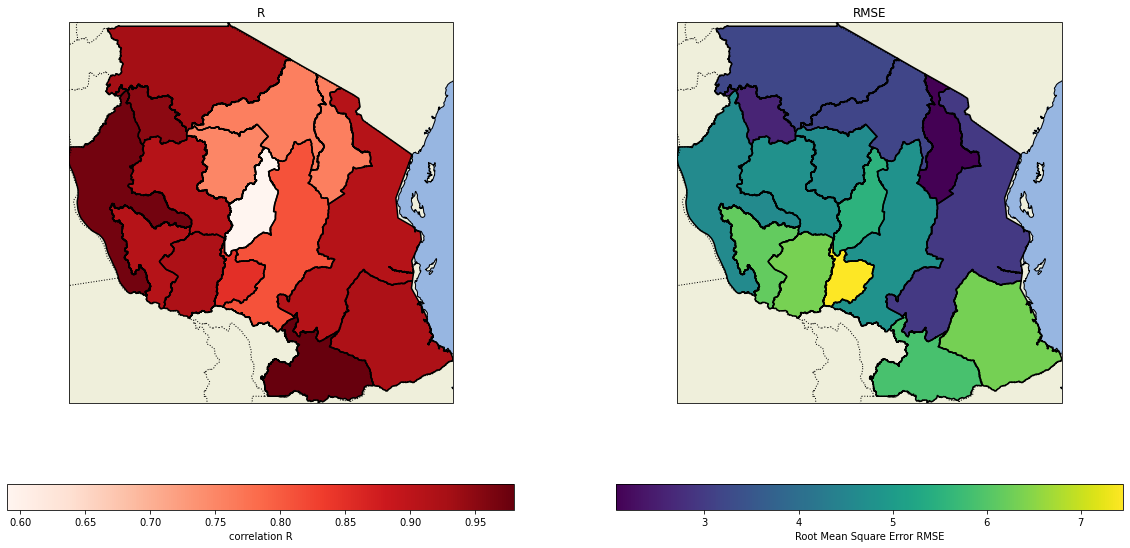

In [33]:
watprov_gdf = TZA_waterProvinces.against_GRACE(PCR_nc_fo='example_data/GRACE/totalWaterStorageThickness_monthAvg_output_2010_Tanzania.nc',
                                               GRACE_nc_fo='example_data/GRACE/GRACE_data_2010_Tanzania.nc',
                                               plot=True)

reading GLEAM file C:\Users\hoch0001\Documents\_code\pcrglobwb_utils\examples\example_data\GLEAM\GLEAM_data_2010_Tanzania.nc
reading PCR-GLOBWB file C:\Users\hoch0001\Documents\_code\pcrglobwb_utils\examples\example_data\GLEAM\totalEvaporation_monthTot_output_2010_Tanzania.nc
extract raw data from nc-files
clipping nc-files to extent of shp-file
computing R and RMSE for polygon with key identifier watprovID 25
computing R and RMSE for polygon with key identifier watprovID 28
computing R and RMSE for polygon with key identifier watprovID 29
computing R and RMSE for polygon with key identifier watprovID 30
computing R and RMSE for polygon with key identifier watprovID 31
computing R and RMSE for polygon with key identifier watprovID 32
computing R and RMSE for polygon with key identifier watprovID 33
computing R and RMSE for polygon with key identifier watprovID 443
computing R and RMSE for polygon with key identifier watprovID 444
computing R and RMSE for polygon with key identifier wat

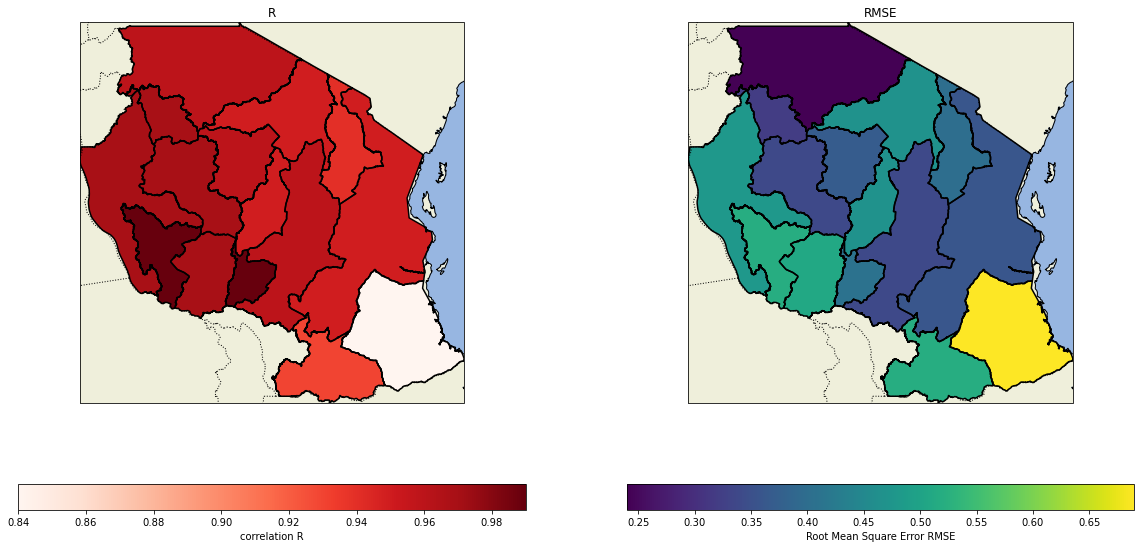

In [34]:
watprov_gdf = TZA_waterProvinces.against_GLEAM(PCR_nc_fo='example_data/GLEAM/totalEvaporation_monthTot_output_2010_Tanzania.nc',
                                               GLEAM_nc_fo='example_data/GLEAM/GLEAM_data_2010_Tanzania.nc',
                                               plot=True)